In [ ]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras import Model
import tensorflow.compat.v1.keras.backend as K

mnist = tf.keras.datasets.mnist

In [2]:
# data parameter
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
60000 train samples
10000 test samples


In [4]:
## START OF SECTION THAT DOES NOT WORK

sess = tf.compat.v1.Session()
K.set_session(sess)

# Build basic model
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer
# if we want to target pre-softmax units

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))


In [5]:
# run model
score = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/1 - 3s - loss: 2.3071 - accuracy: 0.1220
Test loss: 2.301892783355713
Test accuracy: 0.122


In [ ]:
# Import DeepExplain
from deepexplain.tf.v2_x import DeepExplain
# tf.compat.v1.keras.backend.get_session()
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    output_tensor = model.layers[-2].output

    print(input_tensor)
    print(output_tensor)
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    K.set_learning_phase(1)
    fModel = Model(inputs=input_tensor, outputs=output_tensor)

    target_tensor = fModel(input_tensor)

    xs = x_test[0:7]
    ys = y_test[0:7]
    print(target_tensor.graph)
    print(input_tensor.graph)

    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    
## END OF SECTION THAT DOES NOT WORK

In [16]:
# Import DeepExplain
from deepexplain.tf.v2_x import DeepExplain

with DeepExplain(session=tf.compat.v1.keras.backend.get_session()) as de:  # <-- init DeepExplain context
    # Build basci model
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax')) 
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    # run model
    model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    output_tensor = model.layers[-2].output
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs=output_tensor)
    
    # target_tensor = fModel(input_tensor) # <- crash here!!!!!!
    target_tensor = fModel(fModel.layers[0].input)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys, window_shape=(5,5,1))
    
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.2543 - accuracy: 0.9228 - val_loss: 0.0986 - val_accuracy: 0.9702
10000/10000 - 4s - loss: 0.1047 - accuracy: 0.9683
Test loss: 0.10465368688032031
Test accuracy: 0.9683
from attribution method
from attribution method
from attribution method
from attribution method


CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 508 ms


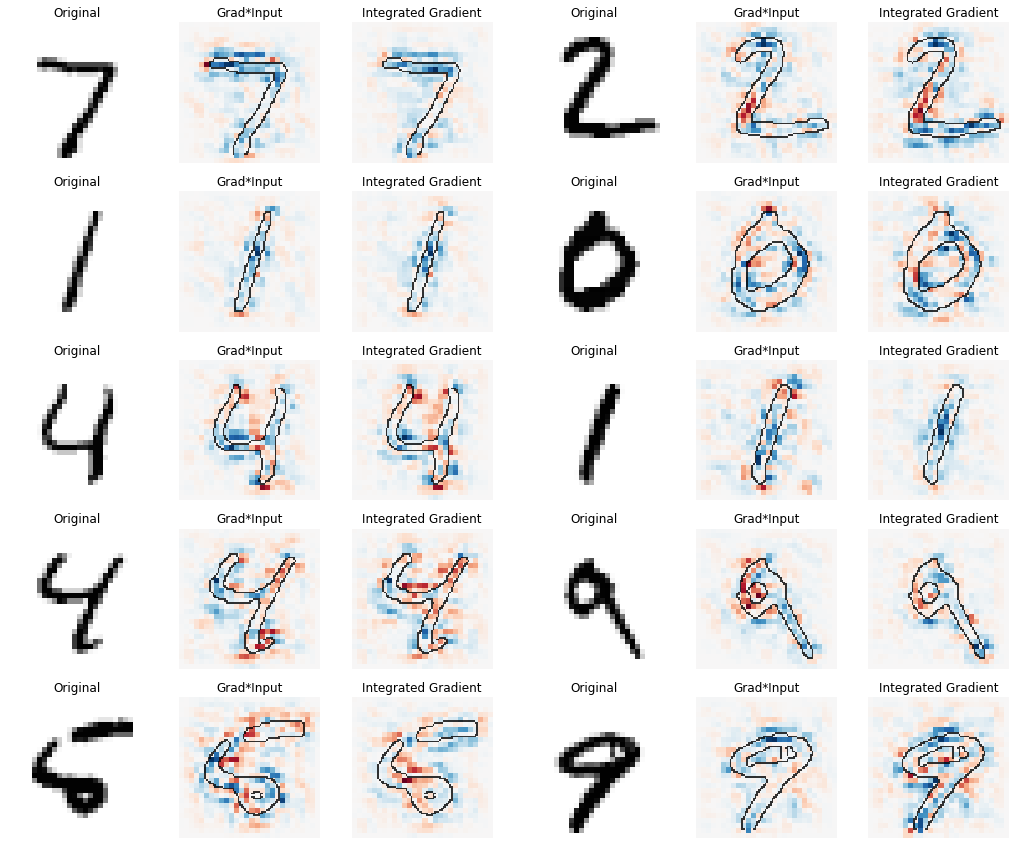

In [18]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_ig)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Integrated Gradient')

/home/ax/miniconda3/envs/masterThesis_tf_2/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


CPU times: user 390 ms, sys: 3.84 ms, total: 394 ms
Wall time: 398 ms


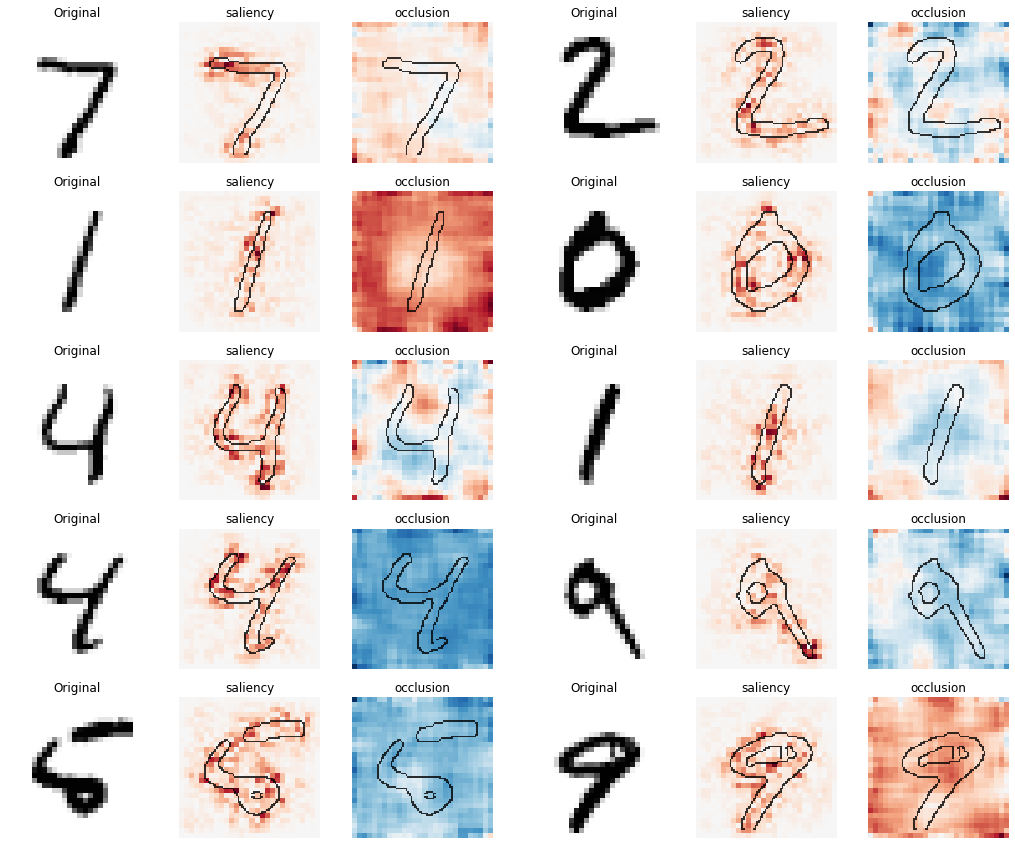

In [17]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_sal, attributions_occ)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('saliency')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('occlusion')

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [ ]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print ("Done")